In [49]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tgs-salt-identification-challenge/depths.csv
/kaggle/input/tgs-salt-identification-challenge/sample_submission.csv
/kaggle/input/tgs-salt-identification-challenge/train.zip
/kaggle/input/tgs-salt-identification-challenge/competition_data.zip
/kaggle/input/tgs-salt-identification-challenge/test.zip
/kaggle/input/tgs-salt-identification-challenge/train.csv
/kaggle/input/tgs-salt-identification-challenge/flamingo.zip


In [50]:
# ===========================================
# Step 0: Import Libraries & Set Seeds
# ===========================================
import numpy as np
import pandas as pd
import os
import zipfile
import cv2
import random
from PIL import Image
from tqdm.notebook import tqdm 
import matplotlib.pyplot as plt
import time 

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split

# --- For Reproducibility ---
SEED = 42
def set_seed(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # if using multi-GPU
    # These are needed for deterministic behavior
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(SEED)
print("Libraries imported and seed set.")

Libraries imported and seed set.


In [51]:
# ===========================================
# Step 1: Define Data Augmentations
# ===========================================
# Define image size
IMG_SIZE = 128 # U-Net works well with powers of 2

# Training augmentations
train_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5, border_mode=cv2.BORDER_CONSTANT),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

# Validation/Test augmentations
val_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])
print("Augmentations defined.")

Augmentations defined.


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:58: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [52]:
# ===========================================
# Step 2: Define UNet Model (Encoder + Decoder)
# ===========================================
class ResNetEncoder(nn.Module):
    def __init__(self, backbone_name='resnet34', pretrained=True):
        super().__init__()
        weights = models.ResNet34_Weights.DEFAULT if pretrained else None
        if backbone_name == 'resnet34':
            backbone = models.resnet34(weights=weights)
            channels = [64, 64, 128, 256, 512]
        elif backbone_name == 'resnet50':
            weights = models.ResNet50_Weights.DEFAULT if pretrained else None
            backbone = models.resnet50(weights=weights)
            channels = [64, 256, 512, 1024, 2048]
        else:
            raise ValueError("Unsupported backbone")

        self.channels = channels
        self.initial = nn.Sequential(
            backbone.conv1,
            backbone.bn1,
            backbone.relu,
            backbone.maxpool
        )
        self.encoder1 = backbone.layer1
        self.encoder2 = backbone.layer2
        self.encoder3 = backbone.layer3
        self.encoder4 = backbone.layer4

    def forward(self, x):
        x0 = self.initial(x)
        x1 = self.encoder1(x0)
        x2 = self.encoder2(x1)
        x3 = self.encoder3(x2)
        x4 = self.encoder4(x3)
        return x0, x1, x2, x3, x4

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, skip_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels + skip_channels, out_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    def forward(self, x, skip):
        x = self.up(x)
        if x.shape[2:] != skip.shape[2:]:
             x = F.interpolate(x, size=skip.shape[2:], mode='bilinear', align_corners=True)
        x = torch.cat([x, skip], dim=1)
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        return x

class UNet(nn.Module):
    def __init__(self, backbone_name='resnet34', pretrained=True, n_classes=1):
        super().__init__()
        self.encoder = ResNetEncoder(backbone_name, pretrained)
        channels = self.encoder.channels

        self.decoder4 = DecoderBlock(channels[4], channels[3], 256)
        self.decoder3 = DecoderBlock(256, channels[2], 128)
        self.decoder2 = DecoderBlock(128, channels[1], 64)
        self.decoder1 = DecoderBlock(64, channels[0], 64)
        self.final_conv = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        input_size = x.shape[2:]
        x0, x1, x2, x3, x4 = self.encoder(x)
        d4 = self.decoder4(x4, x3)
        d3 = self.decoder3(d4, x2)
        d2 = self.decoder2(d3, x1)
        d1 = self.decoder1(d2, x0)
        out = self.final_conv(d1)
        out = F.interpolate(out, size=input_size, mode='bilinear', align_corners=True)
        return out

print("U-Net Model defined.")

U-Net Model defined.


In [53]:
# ===========================================
# Step 3: Loss Functions
# ===========================================
class StableBCELoss(torch.nn.modules.Module):
    def __init__(self):
         super(StableBCELoss, self).__init__()
    def forward(self, input, target):
         neg_abs = - input.abs()
         loss = input.clamp(min=0) - input * target + (1 + neg_abs.exp()).log()
         return loss.mean()
class BCEDiceLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.bce = StableBCELoss()

    def forward(self, logits, targets):
        bce_loss = self.bce(logits, targets)  # no sigmoid here!
        probs = torch.sigmoid(logits)         # apply sigmoid separately for dice
        intersection = (probs * targets).sum()
        dice_loss = 1 - (2. * intersection + 1e-6) / (probs.sum() + targets.sum() + 1e-6)
        return bce_loss + dice_loss
def mean(l, ignore_nan=False, empty=0):
    l = iter(l)
    if ignore_nan:
        l = ifilterfalse(np.isnan, l)
    try:
        n = 1
        acc = next(l)
    except StopIteration:
        if empty == 'raise':
            raise ValueError('Empty mean')
        return empty
    for n, v in enumerate(l, 2):
        acc += v
    if n == 1:
        return acc
    return acc / n
def lovasz_grad(gt_sorted):
    p = len(gt_sorted)
    gts = gt_sorted.sum()
    intersection = gts - gt_sorted.float().cumsum(0)
    union = gts + (1 - gt_sorted).float().cumsum(0)
    jaccard = 1. - intersection / union
    if p > 1:
        jaccard[1:p] = jaccard[1:p] - jaccard[0:-1]
    return jaccard
def lovasz_hinge(logits, labels, per_image=True, ignore=None):
    if per_image:
        loss = mean(lovasz_hinge_flat(*flatten_binary_scores(log.unsqueeze(0), lab.unsqueeze(0), ignore))
                          for log, lab in zip(logits, labels))
    else:
        loss = lovasz_hinge_flat(*flatten_binary_scores(logits, labels, ignore))
    return loss
def lovasz_hinge_flat(logits, labels, ignore=None):
    if ignore is None:
        logits, labels = logits.view(-1), labels.view(-1)
    else:
        mask = (labels != ignore)
        logits, labels = logits[mask], labels[mask]
    signs = 2. * labels.float() - 1.
    errors = 1. - logits * signs
    errors_sorted, perm = torch.sort(errors, descending=True)
    perm = perm.data
    gt_sorted = labels[perm]
    grad = lovasz_grad(gt_sorted)
    loss = torch.dot(F.relu(errors_sorted), grad)
    return loss
def flatten_binary_scores(scores, labels, ignore=None):
    scores = scores.view(-1)
    labels = labels.view(-1)
    if ignore is None:
        return scores, labels
    valid = (labels != ignore)
    return scores[valid], labels[valid]

class LovaszLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, logits, targets):
        logits = logits.squeeze(1)  # (B,1,H,W) -> (B,H,W)
        targets = targets.squeeze(1)
        return lovasz_hinge(logits, targets)

class ComboLoss(nn.Module):
    def __init__(self, weight_bce_dice=0.5, weight_lovasz=0.5):
        super().__init__()
        self.bce_dice = BCEDiceLoss()
        self.lovasz = LovaszLoss()
        self.w1 = weight_bce_dice
        self.w2 = weight_lovasz

    def forward(self, logits, targets):
        loss1 = self.bce_dice(logits, targets)
        loss2 = self.lovasz(logits, targets)
        return self.w1 * loss1 + self.w2 * loss2
print("Loss functions defined.")

Loss functions defined.


In [54]:
# ===========================================
# Step 4: Data Loading, Filtering, and Split
# ===========================================
# --- Unzip Data ---
import os
import zipfile
import shutil

# Define paths
train_zip_path = '/kaggle/input/tgs-salt-identification-challenge/train.zip'
test_zip_path = '/kaggle/input/tgs-salt-identification-challenge/test.zip'
working_dir = '/kaggle/working/'

# Check current working directory contents
print("Before extraction, working directory contains:", os.listdir(working_dir))

# Temporary extraction directory
temp_dir = os.path.join(working_dir, 'temp_extract')
os.makedirs(temp_dir, exist_ok=True)

# Extract and organize train data
if not os.path.exists(os.path.join(working_dir, 'train')):
    print("Extracting train.zip...")
    with zipfile.ZipFile(train_zip_path, 'r') as zip_ref:
        zip_ref.extractall(temp_dir)
    
    # Create train directory
    os.makedirs(os.path.join(working_dir, 'train'), exist_ok=True)
    
    # Move extracted content to train directory
    for item in os.listdir(temp_dir):
        src = os.path.join(temp_dir, item)
        dst = os.path.join(working_dir, 'train', item)
        shutil.move(src, dst)
    
    print("Train.zip extracted and organized!")
else:
    print("Train directory already exists.")

# Clean up temp directory
if os.path.exists(temp_dir):
    os.rmdir(temp_dir)

# Extract and organize test data
temp_dir = os.path.join(working_dir, 'temp_extract')
os.makedirs(temp_dir, exist_ok=True)

if not os.path.exists(os.path.join(working_dir, 'test')):
    print("Extracting test.zip...")
    with zipfile.ZipFile(test_zip_path, 'r') as zip_ref:
        zip_ref.extractall(temp_dir)
    
    # Create test directory
    os.makedirs(os.path.join(working_dir, 'test'), exist_ok=True)
    
    # Move extracted content to test directory
    for item in os.listdir(temp_dir):
        src = os.path.join(temp_dir, item)
        dst = os.path.join(working_dir, 'test', item)
        shutil.move(src, dst)
    
    print("Test.zip extracted and organized!")
else:
    print("Test directory already exists.")

# Clean up temp directory
if os.path.exists(temp_dir):
    os.rmdir(temp_dir)

# Check the final directory structure
print("\nAfter extraction, working directory contains:", os.listdir(working_dir))
if os.path.exists(os.path.join(working_dir, 'train')):
    print("Train directory contains:", os.listdir(os.path.join(working_dir, 'train')))
if os.path.exists(os.path.join(working_dir, 'test')):
    print("Test directory contains:", os.listdir(os.path.join(working_dir, 'test')))

Before extraction, working directory contains: ['models', 'models.zip', 'results.zip', '.virtual_documents', 'results', 'train', 'test', 'submission.csv']
Train directory already exists.
Test directory already exists.

After extraction, working directory contains: ['models', 'models.zip', 'results.zip', '.virtual_documents', 'results', 'train', 'test', 'submission.csv']
Train directory contains: ['masks', 'images']
Test directory contains: ['images']


In [55]:
# --- Set Paths ---
TRAIN_IMAGE_DIR = '/kaggle/working/train/images'
TRAIN_MASK_DIR = '/kaggle/working/train/masks'
TEST_IMAGE_DIR = '/kaggle/working/test/images'

# --- Load Train Filenames ---
train_ids = [f.split('.')[0] for f in os.listdir(TRAIN_IMAGE_DIR) if f.endswith('.png')]
train_image_paths = [os.path.join(TRAIN_IMAGE_DIR, f"{img_id}.png") for img_id in train_ids]
train_mask_paths = [os.path.join(TRAIN_MASK_DIR, f"{img_id}.png") for img_id in train_ids]

# --- Train/Validation Split (using all data for now) ---
train_images, val_images, train_masks, val_masks = train_test_split(
    train_image_paths, # Use all images
    train_mask_paths,
    test_size=0.2,
    random_state=SEED
)

print(f"Total training images: {len(train_ids)}")
print(f"Training images after split: {len(train_images)}")
print(f"Validation images: {len(val_images)}")

# --- Load Test Filenames ---
test_ids = sorted([f.split('.')[0] for f in os.listdir(TEST_IMAGE_DIR) if f.endswith('.png')]) # Sort for consistent submission order
test_image_paths = [os.path.join(TEST_IMAGE_DIR, f"{img_id}.png") for img_id in test_ids]
print(f"Test images: {len(test_ids)}")

Total training images: 4000
Training images after split: 3200
Validation images: 800
Test images: 18000


In [56]:
# ===========================================
# Step 5: Define SaltDataset and Create DataLoaders
# ===========================================
class SaltDataset(Dataset):
    def __init__(self, image_paths, mask_paths=None, transform=None, is_test=False):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform
        self.is_test = is_test

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.is_test:
            if self.transform:
                augmented = self.transform(image=image)
                image = augmented['image']
            image_id = os.path.basename(image_path).split('.')[0]
            return image, image_id
        else:
            mask_path = self.mask_paths[idx]
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            if mask is None: 
                mask = np.zeros((101, 101), dtype=np.uint8) 

            if self.transform:
                augmented = self.transform(image=image, mask=mask)
                image = augmented['image']
                mask = augmented['mask']

            if mask.ndim == 2:
                 mask = mask.unsqueeze(0)
            mask = mask.float() / 255.0
            return image, mask

# --- Create Datasets ---
train_dataset = SaltDataset(train_images, train_masks, transform=train_transform)
val_dataset = SaltDataset(val_images, val_masks, transform=val_transform)
test_dataset = SaltDataset(test_image_paths, mask_paths=None, transform=val_transform, is_test=True)

# --- Create DataLoaders ---
BATCH_SIZE = 32
NUM_WORKERS = 2

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True, drop_last=True) # drop_last helps with batch norm stability
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

print("Datasets and DataLoaders are ready!")

Datasets and DataLoaders are ready!


In [57]:
# ===========================================
# Step 6: IoU Metric and Train/Validate Loop
# ===========================================
def compute_iou(preds, targets, threshold=0.5, smooth=1e-6):
    preds = torch.sigmoid(preds)
    preds_binary = (preds > threshold).float()
    targets_binary = (targets > 0.5).float()
    intersection = (preds_binary * targets_binary).sum(dim=(1, 2, 3))
    union = (preds_binary + targets_binary).sum(dim=(1, 2, 3)) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou.mean()

def train_validate_epoch(model, train_loader, val_loader, optimizer, criterion, device, scheduler=None):
    # --- Training Phase ---
    model.train()
    train_loss = 0.0
    train_iou = 0.0
    train_pbar = tqdm(train_loader, desc="Training", leave=False)
    for images, masks in train_pbar:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        batch_loss = loss.item()
        batch_iou = compute_iou(outputs.detach(), masks).item()
        train_loss += batch_loss
        train_iou += batch_iou
        train_pbar.set_postfix(loss=f"{batch_loss:.4f}", iou=f"{batch_iou:.4f}")
    avg_train_loss = train_loss / len(train_loader)
    avg_train_iou = train_iou / len(train_loader)

    # --- Validation Phase ---
    model.eval()
    val_loss = 0.0
    val_iou = 0.0
    val_pbar = tqdm(val_loader, desc="Validation", leave=False)
    with torch.no_grad():
        for images, masks in val_pbar:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            batch_loss = loss.item()
            batch_iou = compute_iou(outputs, masks).item()
            val_loss += batch_loss
            val_iou += batch_iou
            val_pbar.set_postfix(loss=f"{batch_loss:.4f}", iou=f"{batch_iou:.4f}")
    avg_val_loss = val_loss / len(val_loader)
    avg_val_iou = val_iou / len(val_loader)

    # --- Scheduler Step ---
    if scheduler:
         scheduler.step(avg_val_loss)

    return avg_train_loss, avg_train_iou, avg_val_loss, avg_val_iou

print("Metrics and Train/Validate loop defined.")

Metrics and Train/Validate loop defined.


In [58]:
# ===========================================
# Step 7: Training Configuration and Execution - Loop through Experiments
# ===========================================
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

NUM_EPOCHS = 20
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-5

# --- Define Experiment Configurations ---
configurations = [
    {'backbone': 'resnet34', 'loss_fn_name': 'ComboLoss'},
    {'backbone': 'resnet34', 'loss_fn_name': 'Lovasz'},
    {'backbone': 'resnet50', 'loss_fn_name': 'ComboLoss'},
    {'backbone': 'resnet50', 'loss_fn_name': 'Lovasz'},
]

all_histories = {}
best_model_metrics = {}

# --- Create Directories ---
os.makedirs("models", exist_ok=True)
os.makedirs("results", exist_ok=True)

# --- Loop Through Configurations ---
for config in configurations:
    backbone_name = config['backbone']
    loss_fn_name = config['loss_fn_name']
    config_name = f"{backbone_name}_{loss_fn_name}" 

    print(f"\n===== Starting Experiment: {config_name} =====")
    start_time = time.time()

    # --- Setup Model, Optimizer, Criterion, Scheduler ---
    set_seed(SEED) 
    model = UNet(backbone_name=backbone_name, pretrained=True).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

    if loss_fn_name == 'ComboLoss':
        criterion = ComboLoss().to(DEVICE)
    elif loss_fn_name == 'Lovasz':
        criterion = LovaszLoss().to(DEVICE)
    else:
        raise ValueError("Unsupported loss function")

    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=5, verbose=True) # Schedule based on Val IoU

    # --- Training Loop for this Configuration ---
    current_best_val_iou = 0.0
    current_best_epoch = 0
    history = {'train_loss': [], 'train_iou': [], 'val_loss': [], 'val_iou': []}

    for epoch in range(1, NUM_EPOCHS + 1):
        print(f"--- Epoch {epoch}/{NUM_EPOCHS} ({config_name}) ---")
        train_loss, train_iou, val_loss, val_iou = train_validate_epoch(
            model, train_loader, val_loader, optimizer, criterion, DEVICE, scheduler=None # Step scheduler manually based on IoU
        )

        # Store history
        history['train_loss'].append(train_loss)
        history['train_iou'].append(train_iou)
        history['val_loss'].append(val_loss)
        history['val_iou'].append(val_iou)

        print(f"Epoch {epoch} Summary - Train Loss: {train_loss:.4f}, Train IoU: {train_iou:.4f} | Val Loss: {val_loss:.4f}, Val IoU: {val_iou:.4f}")


        scheduler.step(val_iou)

        # Save the best model for this configuration
        if val_iou > current_best_val_iou:
            current_best_val_iou = val_iou
            current_best_epoch = epoch
            model_save_path = f"models/best_model_{config_name}.pth"
            torch.save(model.state_dict(), model_save_path)
            print(f"✨ Best model for {config_name} saved to {model_save_path} (Val IoU: {current_best_val_iou:.4f})")

    end_time = time.time()
    print(f"--- Experiment {config_name} Finished ---")
    print(f"Best Validation IoU: {current_best_val_iou:.4f} at Epoch {current_best_epoch}")
    print(f"Time taken: {end_time - start_time:.2f} seconds")

    # Store results for this configuration
    all_histories[config_name] = history
    best_model_metrics[config_name] = {'best_val_iou': current_best_val_iou, 'best_epoch': current_best_epoch}

Using device: cuda

===== Starting Experiment: resnet34_ComboLoss =====
--- Epoch 1/20 (resnet34_ComboLoss) ---


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1 Summary - Train Loss: 1.0533, Train IoU: 0.4896 | Val Loss: 0.7913, Val IoU: 0.6459
✨ Best model for resnet34_ComboLoss saved to models/best_model_resnet34_ComboLoss.pth (Val IoU: 0.6459)
--- Epoch 2/20 (resnet34_ComboLoss) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 2 Summary - Train Loss: 0.7675, Train IoU: 0.6463 | Val Loss: 0.5824, Val IoU: 0.7259
✨ Best model for resnet34_ComboLoss saved to models/best_model_resnet34_ComboLoss.pth (Val IoU: 0.7259)
--- Epoch 3/20 (resnet34_ComboLoss) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 3 Summary - Train Loss: 0.6509, Train IoU: 0.6947 | Val Loss: 0.5639, Val IoU: 0.7420
✨ Best model for resnet34_ComboLoss saved to models/best_model_resnet34_ComboLoss.pth (Val IoU: 0.7420)
--- Epoch 4/20 (resnet34_ComboLoss) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 4 Summary - Train Loss: 0.5964, Train IoU: 0.7187 | Val Loss: 0.5005, Val IoU: 0.7657
✨ Best model for resnet34_ComboLoss saved to models/best_model_resnet34_ComboLoss.pth (Val IoU: 0.7657)
--- Epoch 5/20 (resnet34_ComboLoss) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 5 Summary - Train Loss: 0.5676, Train IoU: 0.7313 | Val Loss: 0.4877, Val IoU: 0.7623
--- Epoch 6/20 (resnet34_ComboLoss) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 6 Summary - Train Loss: 0.5272, Train IoU: 0.7464 | Val Loss: 0.4628, Val IoU: 0.7765
✨ Best model for resnet34_ComboLoss saved to models/best_model_resnet34_ComboLoss.pth (Val IoU: 0.7765)
--- Epoch 7/20 (resnet34_ComboLoss) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 7 Summary - Train Loss: 0.5148, Train IoU: 0.7549 | Val Loss: 0.4895, Val IoU: 0.7718
--- Epoch 8/20 (resnet34_ComboLoss) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 8 Summary - Train Loss: 0.4921, Train IoU: 0.7669 | Val Loss: 0.4591, Val IoU: 0.7993
✨ Best model for resnet34_ComboLoss saved to models/best_model_resnet34_ComboLoss.pth (Val IoU: 0.7993)
--- Epoch 9/20 (resnet34_ComboLoss) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 9 Summary - Train Loss: 0.4740, Train IoU: 0.7765 | Val Loss: 0.4666, Val IoU: 0.7951
--- Epoch 10/20 (resnet34_ComboLoss) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 10 Summary - Train Loss: 0.4835, Train IoU: 0.7708 | Val Loss: 0.4134, Val IoU: 0.7983
--- Epoch 11/20 (resnet34_ComboLoss) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 11 Summary - Train Loss: 0.4500, Train IoU: 0.7784 | Val Loss: 0.4103, Val IoU: 0.8013
✨ Best model for resnet34_ComboLoss saved to models/best_model_resnet34_ComboLoss.pth (Val IoU: 0.8013)
--- Epoch 12/20 (resnet34_ComboLoss) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 12 Summary - Train Loss: 0.4291, Train IoU: 0.7881 | Val Loss: 0.4325, Val IoU: 0.8050
✨ Best model for resnet34_ComboLoss saved to models/best_model_resnet34_ComboLoss.pth (Val IoU: 0.8050)
--- Epoch 13/20 (resnet34_ComboLoss) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 13 Summary - Train Loss: 0.4305, Train IoU: 0.7946 | Val Loss: 0.3829, Val IoU: 0.8151
✨ Best model for resnet34_ComboLoss saved to models/best_model_resnet34_ComboLoss.pth (Val IoU: 0.8151)
--- Epoch 14/20 (resnet34_ComboLoss) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 14 Summary - Train Loss: 0.4314, Train IoU: 0.7898 | Val Loss: 0.3831, Val IoU: 0.8018
--- Epoch 15/20 (resnet34_ComboLoss) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 15 Summary - Train Loss: 0.4124, Train IoU: 0.7946 | Val Loss: 0.4263, Val IoU: 0.8052
--- Epoch 16/20 (resnet34_ComboLoss) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 16 Summary - Train Loss: 0.4088, Train IoU: 0.8028 | Val Loss: 0.4229, Val IoU: 0.8223
✨ Best model for resnet34_ComboLoss saved to models/best_model_resnet34_ComboLoss.pth (Val IoU: 0.8223)
--- Epoch 17/20 (resnet34_ComboLoss) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 17 Summary - Train Loss: 0.4175, Train IoU: 0.7983 | Val Loss: 0.4006, Val IoU: 0.8073
--- Epoch 18/20 (resnet34_ComboLoss) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 18 Summary - Train Loss: 0.3993, Train IoU: 0.8038 | Val Loss: 0.3699, Val IoU: 0.8165
--- Epoch 19/20 (resnet34_ComboLoss) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 19 Summary - Train Loss: 0.4142, Train IoU: 0.8013 | Val Loss: 0.4055, Val IoU: 0.8095
--- Epoch 20/20 (resnet34_ComboLoss) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 20 Summary - Train Loss: 0.3966, Train IoU: 0.8022 | Val Loss: 0.3804, Val IoU: 0.8161
--- Experiment resnet34_ComboLoss Finished ---
Best Validation IoU: 0.8223 at Epoch 16
Time taken: 248.89 seconds

===== Starting Experiment: resnet34_Lovasz =====
--- Epoch 1/20 (resnet34_Lovasz) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1 Summary - Train Loss: 0.9587, Train IoU: 0.4393 | Val Loss: 0.7789, Val IoU: 0.5942
✨ Best model for resnet34_Lovasz saved to models/best_model_resnet34_Lovasz.pth (Val IoU: 0.5942)
--- Epoch 2/20 (resnet34_Lovasz) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 2 Summary - Train Loss: 0.8122, Train IoU: 0.5603 | Val Loss: 0.7429, Val IoU: 0.6400
✨ Best model for resnet34_Lovasz saved to models/best_model_resnet34_Lovasz.pth (Val IoU: 0.6400)
--- Epoch 3/20 (resnet34_Lovasz) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 3 Summary - Train Loss: 0.7623, Train IoU: 0.5849 | Val Loss: 0.6649, Val IoU: 0.6073
--- Epoch 4/20 (resnet34_Lovasz) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 4 Summary - Train Loss: 0.6945, Train IoU: 0.5991 | Val Loss: 0.5912, Val IoU: 0.6502
✨ Best model for resnet34_Lovasz saved to models/best_model_resnet34_Lovasz.pth (Val IoU: 0.6502)
--- Epoch 5/20 (resnet34_Lovasz) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 5 Summary - Train Loss: 0.6374, Train IoU: 0.6363 | Val Loss: 0.5497, Val IoU: 0.6939
✨ Best model for resnet34_Lovasz saved to models/best_model_resnet34_Lovasz.pth (Val IoU: 0.6939)
--- Epoch 6/20 (resnet34_Lovasz) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 6 Summary - Train Loss: 0.5961, Train IoU: 0.6582 | Val Loss: 0.5172, Val IoU: 0.7033
✨ Best model for resnet34_Lovasz saved to models/best_model_resnet34_Lovasz.pth (Val IoU: 0.7033)
--- Epoch 7/20 (resnet34_Lovasz) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 7 Summary - Train Loss: 0.5741, Train IoU: 0.6572 | Val Loss: 0.4973, Val IoU: 0.6964
--- Epoch 8/20 (resnet34_Lovasz) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 8 Summary - Train Loss: 0.5944, Train IoU: 0.6587 | Val Loss: 0.4695, Val IoU: 0.7196
✨ Best model for resnet34_Lovasz saved to models/best_model_resnet34_Lovasz.pth (Val IoU: 0.7196)
--- Epoch 9/20 (resnet34_Lovasz) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 9 Summary - Train Loss: 0.5623, Train IoU: 0.6732 | Val Loss: 0.4703, Val IoU: 0.7330
✨ Best model for resnet34_Lovasz saved to models/best_model_resnet34_Lovasz.pth (Val IoU: 0.7330)
--- Epoch 10/20 (resnet34_Lovasz) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 10 Summary - Train Loss: 0.5458, Train IoU: 0.6975 | Val Loss: 0.4733, Val IoU: 0.7193
--- Epoch 11/20 (resnet34_Lovasz) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 11 Summary - Train Loss: 0.5479, Train IoU: 0.6828 | Val Loss: 0.4240, Val IoU: 0.7498
✨ Best model for resnet34_Lovasz saved to models/best_model_resnet34_Lovasz.pth (Val IoU: 0.7498)
--- Epoch 12/20 (resnet34_Lovasz) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 12 Summary - Train Loss: 0.5185, Train IoU: 0.6966 | Val Loss: 0.4435, Val IoU: 0.7317
--- Epoch 13/20 (resnet34_Lovasz) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 13 Summary - Train Loss: 0.5369, Train IoU: 0.6846 | Val Loss: 0.4303, Val IoU: 0.7644
✨ Best model for resnet34_Lovasz saved to models/best_model_resnet34_Lovasz.pth (Val IoU: 0.7644)
--- Epoch 14/20 (resnet34_Lovasz) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 14 Summary - Train Loss: 0.5364, Train IoU: 0.6860 | Val Loss: 0.4484, Val IoU: 0.7046
--- Epoch 15/20 (resnet34_Lovasz) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 15 Summary - Train Loss: 0.5619, Train IoU: 0.6541 | Val Loss: 0.4513, Val IoU: 0.7223
--- Epoch 16/20 (resnet34_Lovasz) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 16 Summary - Train Loss: 0.5806, Train IoU: 0.6597 | Val Loss: 0.5187, Val IoU: 0.7189
--- Epoch 17/20 (resnet34_Lovasz) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 17 Summary - Train Loss: 0.5472, Train IoU: 0.6705 | Val Loss: 0.4921, Val IoU: 0.6841
--- Epoch 18/20 (resnet34_Lovasz) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 18 Summary - Train Loss: 0.5681, Train IoU: 0.6610 | Val Loss: 0.4736, Val IoU: 0.7044
--- Epoch 19/20 (resnet34_Lovasz) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 19 Summary - Train Loss: 0.5624, Train IoU: 0.6625 | Val Loss: 0.4717, Val IoU: 0.7281
--- Epoch 20/20 (resnet34_Lovasz) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 20 Summary - Train Loss: 0.5189, Train IoU: 0.6862 | Val Loss: 0.4441, Val IoU: 0.7310
--- Experiment resnet34_Lovasz Finished ---
Best Validation IoU: 0.7644 at Epoch 13
Time taken: 244.68 seconds

===== Starting Experiment: resnet50_ComboLoss =====
--- Epoch 1/20 (resnet50_ComboLoss) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1 Summary - Train Loss: 0.9482, Train IoU: 0.5492 | Val Loss: 0.6657, Val IoU: 0.6890
✨ Best model for resnet50_ComboLoss saved to models/best_model_resnet50_ComboLoss.pth (Val IoU: 0.6890)
--- Epoch 2/20 (resnet50_ComboLoss) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 2 Summary - Train Loss: 0.6832, Train IoU: 0.6746 | Val Loss: 0.5824, Val IoU: 0.7279
✨ Best model for resnet50_ComboLoss saved to models/best_model_resnet50_ComboLoss.pth (Val IoU: 0.7279)
--- Epoch 3/20 (resnet50_ComboLoss) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 3 Summary - Train Loss: 0.6234, Train IoU: 0.7086 | Val Loss: 0.5052, Val IoU: 0.7533
✨ Best model for resnet50_ComboLoss saved to models/best_model_resnet50_ComboLoss.pth (Val IoU: 0.7533)
--- Epoch 4/20 (resnet50_ComboLoss) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 4 Summary - Train Loss: 0.5622, Train IoU: 0.7357 | Val Loss: 0.4732, Val IoU: 0.7724
✨ Best model for resnet50_ComboLoss saved to models/best_model_resnet50_ComboLoss.pth (Val IoU: 0.7724)
--- Epoch 5/20 (resnet50_ComboLoss) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 5 Summary - Train Loss: 0.5367, Train IoU: 0.7453 | Val Loss: 0.4398, Val IoU: 0.7818
✨ Best model for resnet50_ComboLoss saved to models/best_model_resnet50_ComboLoss.pth (Val IoU: 0.7818)
--- Epoch 6/20 (resnet50_ComboLoss) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 6 Summary - Train Loss: 0.5141, Train IoU: 0.7601 | Val Loss: 0.4342, Val IoU: 0.7868
✨ Best model for resnet50_ComboLoss saved to models/best_model_resnet50_ComboLoss.pth (Val IoU: 0.7868)
--- Epoch 7/20 (resnet50_ComboLoss) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 7 Summary - Train Loss: 0.4933, Train IoU: 0.7666 | Val Loss: 0.4194, Val IoU: 0.8002
✨ Best model for resnet50_ComboLoss saved to models/best_model_resnet50_ComboLoss.pth (Val IoU: 0.8002)
--- Epoch 8/20 (resnet50_ComboLoss) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 8 Summary - Train Loss: 0.4604, Train IoU: 0.7816 | Val Loss: 0.3972, Val IoU: 0.8057
✨ Best model for resnet50_ComboLoss saved to models/best_model_resnet50_ComboLoss.pth (Val IoU: 0.8057)
--- Epoch 9/20 (resnet50_ComboLoss) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 9 Summary - Train Loss: 0.4583, Train IoU: 0.7777 | Val Loss: 0.4054, Val IoU: 0.8060
✨ Best model for resnet50_ComboLoss saved to models/best_model_resnet50_ComboLoss.pth (Val IoU: 0.8060)
--- Epoch 10/20 (resnet50_ComboLoss) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 10 Summary - Train Loss: 0.4228, Train IoU: 0.7958 | Val Loss: 0.4172, Val IoU: 0.8056
--- Epoch 11/20 (resnet50_ComboLoss) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 11 Summary - Train Loss: 0.4217, Train IoU: 0.7973 | Val Loss: 0.3899, Val IoU: 0.8143
✨ Best model for resnet50_ComboLoss saved to models/best_model_resnet50_ComboLoss.pth (Val IoU: 0.8143)
--- Epoch 12/20 (resnet50_ComboLoss) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 12 Summary - Train Loss: 0.4227, Train IoU: 0.7985 | Val Loss: 0.3727, Val IoU: 0.8234
✨ Best model for resnet50_ComboLoss saved to models/best_model_resnet50_ComboLoss.pth (Val IoU: 0.8234)
--- Epoch 13/20 (resnet50_ComboLoss) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 13 Summary - Train Loss: 0.3975, Train IoU: 0.8064 | Val Loss: 0.3765, Val IoU: 0.8131
--- Epoch 14/20 (resnet50_ComboLoss) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 14 Summary - Train Loss: 0.3960, Train IoU: 0.8030 | Val Loss: 0.3711, Val IoU: 0.8224
--- Epoch 15/20 (resnet50_ComboLoss) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 15 Summary - Train Loss: 0.4066, Train IoU: 0.8049 | Val Loss: 0.3729, Val IoU: 0.8210
--- Epoch 16/20 (resnet50_ComboLoss) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 16 Summary - Train Loss: 0.3792, Train IoU: 0.8150 | Val Loss: 0.3476, Val IoU: 0.8279
✨ Best model for resnet50_ComboLoss saved to models/best_model_resnet50_ComboLoss.pth (Val IoU: 0.8279)
--- Epoch 17/20 (resnet50_ComboLoss) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 17 Summary - Train Loss: 0.3759, Train IoU: 0.8165 | Val Loss: 0.3649, Val IoU: 0.8215
--- Epoch 18/20 (resnet50_ComboLoss) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 18 Summary - Train Loss: 0.3668, Train IoU: 0.8179 | Val Loss: 0.3909, Val IoU: 0.8191
--- Epoch 19/20 (resnet50_ComboLoss) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 19 Summary - Train Loss: 0.3722, Train IoU: 0.8153 | Val Loss: 0.3919, Val IoU: 0.8250
--- Epoch 20/20 (resnet50_ComboLoss) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 20 Summary - Train Loss: 0.3676, Train IoU: 0.8197 | Val Loss: 0.3566, Val IoU: 0.8273
--- Experiment resnet50_ComboLoss Finished ---
Best Validation IoU: 0.8279 at Epoch 16
Time taken: 691.00 seconds

===== Starting Experiment: resnet50_Lovasz =====
--- Epoch 1/20 (resnet50_Lovasz) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1 Summary - Train Loss: 0.9558, Train IoU: 0.4922 | Val Loss: 0.6900, Val IoU: 0.6683
✨ Best model for resnet50_Lovasz saved to models/best_model_resnet50_Lovasz.pth (Val IoU: 0.6683)
--- Epoch 2/20 (resnet50_Lovasz) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 2 Summary - Train Loss: 0.7034, Train IoU: 0.6663 | Val Loss: 0.5543, Val IoU: 0.7295
✨ Best model for resnet50_Lovasz saved to models/best_model_resnet50_Lovasz.pth (Val IoU: 0.7295)
--- Epoch 3/20 (resnet50_Lovasz) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 3 Summary - Train Loss: 0.6172, Train IoU: 0.7025 | Val Loss: 0.5312, Val IoU: 0.7549
✨ Best model for resnet50_Lovasz saved to models/best_model_resnet50_Lovasz.pth (Val IoU: 0.7549)
--- Epoch 4/20 (resnet50_Lovasz) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 4 Summary - Train Loss: 0.5746, Train IoU: 0.7217 | Val Loss: 0.4637, Val IoU: 0.7777
✨ Best model for resnet50_Lovasz saved to models/best_model_resnet50_Lovasz.pth (Val IoU: 0.7777)
--- Epoch 5/20 (resnet50_Lovasz) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 5 Summary - Train Loss: 0.5289, Train IoU: 0.7451 | Val Loss: 0.4562, Val IoU: 0.7826
✨ Best model for resnet50_Lovasz saved to models/best_model_resnet50_Lovasz.pth (Val IoU: 0.7826)
--- Epoch 6/20 (resnet50_Lovasz) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 6 Summary - Train Loss: 0.5099, Train IoU: 0.7551 | Val Loss: 0.4511, Val IoU: 0.7890
✨ Best model for resnet50_Lovasz saved to models/best_model_resnet50_Lovasz.pth (Val IoU: 0.7890)
--- Epoch 7/20 (resnet50_Lovasz) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 7 Summary - Train Loss: 0.5136, Train IoU: 0.7543 | Val Loss: 0.4635, Val IoU: 0.7821
--- Epoch 8/20 (resnet50_Lovasz) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 8 Summary - Train Loss: 0.4688, Train IoU: 0.7722 | Val Loss: 0.4064, Val IoU: 0.7993
✨ Best model for resnet50_Lovasz saved to models/best_model_resnet50_Lovasz.pth (Val IoU: 0.7993)
--- Epoch 9/20 (resnet50_Lovasz) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 9 Summary - Train Loss: 0.4634, Train IoU: 0.7757 | Val Loss: 0.4081, Val IoU: 0.8021
✨ Best model for resnet50_Lovasz saved to models/best_model_resnet50_Lovasz.pth (Val IoU: 0.8021)
--- Epoch 10/20 (resnet50_Lovasz) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 10 Summary - Train Loss: 0.4461, Train IoU: 0.7835 | Val Loss: 0.4138, Val IoU: 0.7981
--- Epoch 11/20 (resnet50_Lovasz) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 11 Summary - Train Loss: 0.4578, Train IoU: 0.7746 | Val Loss: 0.3974, Val IoU: 0.8057
✨ Best model for resnet50_Lovasz saved to models/best_model_resnet50_Lovasz.pth (Val IoU: 0.8057)
--- Epoch 12/20 (resnet50_Lovasz) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 12 Summary - Train Loss: 0.4389, Train IoU: 0.7840 | Val Loss: 0.3809, Val IoU: 0.8071
✨ Best model for resnet50_Lovasz saved to models/best_model_resnet50_Lovasz.pth (Val IoU: 0.8071)
--- Epoch 13/20 (resnet50_Lovasz) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 13 Summary - Train Loss: 0.4345, Train IoU: 0.7881 | Val Loss: 0.3920, Val IoU: 0.8056
--- Epoch 14/20 (resnet50_Lovasz) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 14 Summary - Train Loss: 0.4378, Train IoU: 0.7783 | Val Loss: 0.4102, Val IoU: 0.7914
--- Epoch 15/20 (resnet50_Lovasz) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 15 Summary - Train Loss: 0.4418, Train IoU: 0.7819 | Val Loss: 0.3818, Val IoU: 0.8084
✨ Best model for resnet50_Lovasz saved to models/best_model_resnet50_Lovasz.pth (Val IoU: 0.8084)
--- Epoch 16/20 (resnet50_Lovasz) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 16 Summary - Train Loss: 0.4399, Train IoU: 0.7839 | Val Loss: 0.4038, Val IoU: 0.8005
--- Epoch 17/20 (resnet50_Lovasz) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 17 Summary - Train Loss: 0.4299, Train IoU: 0.7886 | Val Loss: 0.3813, Val IoU: 0.8114
✨ Best model for resnet50_Lovasz saved to models/best_model_resnet50_Lovasz.pth (Val IoU: 0.8114)
--- Epoch 18/20 (resnet50_Lovasz) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 18 Summary - Train Loss: 0.4352, Train IoU: 0.7846 | Val Loss: 0.4046, Val IoU: 0.8019
--- Epoch 19/20 (resnet50_Lovasz) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 19 Summary - Train Loss: 0.4333, Train IoU: 0.7857 | Val Loss: 0.3967, Val IoU: 0.8032
--- Epoch 20/20 (resnet50_Lovasz) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 20 Summary - Train Loss: 0.4148, Train IoU: 0.7898 | Val Loss: 0.3876, Val IoU: 0.7983
--- Experiment resnet50_Lovasz Finished ---
Best Validation IoU: 0.8114 at Epoch 17
Time taken: 687.57 seconds



--- Generating Comparison Plot ---


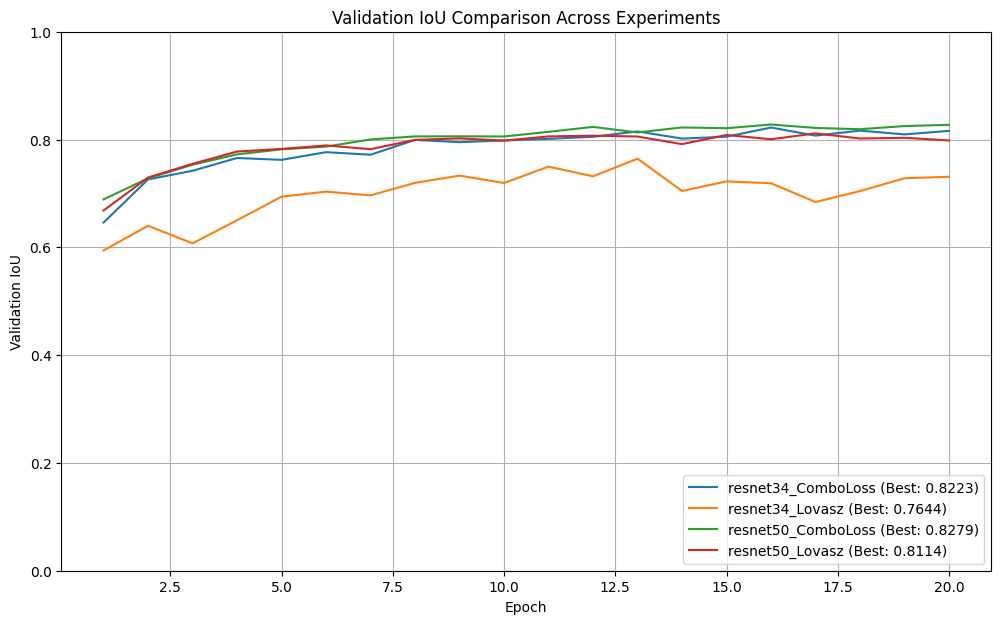

Comparison plot saved to results/validation_iou_comparison.png


In [59]:
# ===========================================
# Step 7b: Comparison Plotting
# ===========================================
print("\n--- Generating Comparison Plot ---")
plt.figure(figsize=(12, 7))

for config_name, history in all_histories.items():
    epochs_range = range(1, len(history['val_iou']) + 1)
    plt.plot(epochs_range, history['val_iou'], label=f"{config_name} (Best: {best_model_metrics[config_name]['best_val_iou']:.4f})")

plt.title('Validation IoU Comparison Across Experiments')
plt.xlabel('Epoch')
plt.ylabel('Validation IoU')
plt.legend(loc='lower right')
plt.grid(True)
plt.ylim(0, 1) # Set y-axis limits for IoU
plt.savefig("results/validation_iou_comparison.png")
plt.show()
print("Comparison plot saved to results/validation_iou_comparison.png")

In [60]:
# ===========================================
# Step 8: Prediction and Submission File Generation (Using Overall Best Model)
# ===========================================

# --- Find the Overall Best Model ---
overall_best_iou = -1.0
best_config_name = None
for config_name, metrics in best_model_metrics.items():
    if metrics['best_val_iou'] > overall_best_iou:
        overall_best_iou = metrics['best_val_iou']
        best_config_name = config_name

print(f"\n--- Overall Best Model based on Validation IoU: {best_config_name} (IoU: {overall_best_iou:.4f}) ---")

# --- Run-Length Encoding Function ---
def rle_encode(img):
    pixels = img.flatten(order='F')
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

# --- Prediction Function ---
def predict_test(model, test_loader, device, threshold=0.5):
    model.eval()
    predictions = {}
    test_pbar = tqdm(test_loader, desc="Predicting", leave=False)
    with torch.no_grad():
        for images, image_ids in test_pbar:
            images = images.to(device)
            outputs = model(images)
            probs = torch.sigmoid(outputs)
            probs_resized = F.interpolate(probs, size=(101, 101), mode='bilinear', align_corners=False)
            preds_binary = (probs_resized > threshold).cpu().numpy().astype(np.uint8)
            for i, img_id in enumerate(image_ids):
                 pred_mask = preds_binary[i].squeeze()
                 predictions[img_id] = pred_mask
    return predictions

# --- Load the Overall Best Model ---
# Re-instantiate the model architecture for the best config
best_backbone = best_config_name.split('_')[0]
best_model = UNet(backbone_name=best_backbone, pretrained=False).to(DEVICE) # No need for pretrained weights now

best_model_path = f"models/best_model_{best_config_name}.pth"
if os.path.exists(best_model_path):
    print(f"Loading overall best model from: {best_model_path}")
    best_model.load_state_dict(torch.load(best_model_path, map_location=DEVICE))
else:
    print(f"Error: Best model path not found ({best_model_path}). Cannot generate submission.")
    # Handle error appropriately, maybe exit or use a default model if available

# --- Perform Prediction with Best Model ---
if os.path.exists(best_model_path):
    test_predictions = predict_test(best_model, test_loader, DEVICE, threshold=0.5) # Adjust threshold if needed

    # --- Generate Submission File ---
    submission_data = []
    for img_id in tqdm(test_ids, desc="Encoding"): # Use sorted test_ids
        if img_id in test_predictions:
            rle = rle_encode(test_predictions[img_id])
        else:
            rle = ''
            print(f"Warning: Prediction missing for image ID: {img_id}")
        submission_data.append({'id': img_id, 'rle_mask': rle})

    submission_df = pd.DataFrame(submission_data)
    submission_df.to_csv('submission.csv', index=False)

    print("\n--- Submission File Generated: submission.csv ---")
    print(submission_df.head())
else:
    print("Submission file not generated due to missing best model.")


--- Overall Best Model based on Validation IoU: resnet50_ComboLoss (IoU: 0.8279) ---
Loading overall best model from: models/best_model_resnet50_ComboLoss.pth


/tmp/ipykernel_31/63944350.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(best_model_path, map_location=DEVICE))


Predicting:   0%|          | 0/563 [00:00<?, ?it/s]

Encoding:   0%|          | 0/18000 [00:00<?, ?it/s]


--- Submission File Generated: submission.csv ---
           id                                           rle_mask
0  0005bb9630  30 72 131 72 231 73 332 73 432 74 532 75 633 7...
1  000a68e46c                                                   
2  000c8dfb2a                                                   
3  000d0a5f6c                                                   
4  001ef8fc87  1 7366 7374 79 7475 71 7576 67 7677 63 7778 58...


In [61]:

print("\nZipping output files...")
if os.path.exists("models"):
    !zip -rq models.zip /kaggle/working/models # Use -q for quiet, -r for recursive
    print("models.zip created.")
if os.path.exists("results"):
    !zip -rq results.zip /kaggle/working/results
    print("results.zip created.")

print("\n--- Script Finished ---")


Zipping output files...
models.zip created.
results.zip created.

--- Script Finished ---
